In [3]:
import sys, os, toml
sys.path.append(os.path.join(sys.path[0], '../..',))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from IPython.display import display, HTML

In [23]:
from data.io import Writer, Reader
config = Reader.read_config(os.path.join(sys.path[0], '../..', 'config', 'endure.toml'))
reader = Reader(config)
writer = Writer(config)
from lsm.cost import EndureQFixedCost, EndureTierLevelCost, EndureKHybridCost
from lsm.lsmtype import LSMTree, LSMSystem, Policy

def wl_to_array(wl_dict):
    return (wl_dict['id'], wl_dict['z0'], wl_dict['z1'], wl_dict['q'], wl_dict['w'])

In [118]:
system_vars = LSMSystem(**config['system'])
tl_cf = EndureTierLevelCost(**config['system'])

df = []
wls = [
    {'id': 0, 'z0': 0.25, 'z1': 0.25, 'q': 0.25, 'w': 0.25},
    {'id': 1, 'z0': 0.05, 'z1': 0.15, 'q': 0.20, 'w': 0.70},
    {'id': 2, 'z0': 0.05, 'z1': 0.05, 'q': 0.45, 'w': 0.45},
]
for wl in wls:
    wl_id, z0, z1, q, w = wl_to_array(wl)
    for h in np.arange(0, system_vars.H, 0.55):
        for T in np.arange(2, 20):
            level_cost = tl_cf.calc_cost(h, T, Policy.Leveling, z0, z1, q, w)
            row = {
                'wl_id': wl_id,
                'h': h,
                'T': T,
                'z0': z0,
                'z1': z1,
                'q': q,
                'w': w,
                'cost': level_cost
            }
            df.append(row)

df = pd.DataFrame(df)

In [119]:
df

,wl_id,h,T,z0,z1,q,w,cost
0,0,0.0,2,0.25,0.25,0.25,0.25,5.211643
1,0,0.0,3,0.25,0.25,0.25,0.25,3.733320
2,0,0.0,4,0.25,0.25,0.25,0.25,3.303988
3,0,0.0,5,0.25,0.25,0.25,0.25,3.139898
4,0,0.0,6,0.25,0.25,0.25,0.25,3.080422
...,...,...,...,...,...,...,...,...
1021,2,9.9,15,0.05,0.05,0.45,0.45,8.980498
1022,2,9.9,16,0.05,0.05,0.45,0.45,9.231678
1023,2,9.9,17,0.05,0.05,0.45,0.45,9.484446
1024,2,9.9,18,0.05,0.05,0.45,0.45,9.738228


In [122]:
def surface_plot(data, xlabel='', ylabel='', zlabel='', ax=None, legend_on=False):
    if ax == None:
        ax = plt.gca()
        
    size_ratios, filter_mem = data['T'].unique(), data['h'].unique()
    x = data.query(f'wl_id == {wl_id}')['T'].values.reshape(filter_mem.size, size_ratios.size)
    y = data.query(f'wl_id == {wl_id}')['h'].values.reshape(filter_mem.size, size_ratios.size)
    surf_data = data.query(f'wl_id == {wl_id}')['cost'].values.reshape(filter_mem.size, size_ratios.size)
    
    surf = ax.plot_surface(x, y, surf_data, cmap='viridis')
    ax.set_zlim([0, 10])
    ax.set_ylim(10, 0)
    ax.set_xlim(2, 20)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_zlabel(zlabel)
    
    return surf

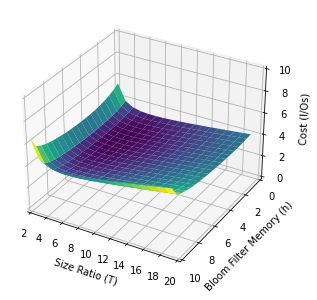

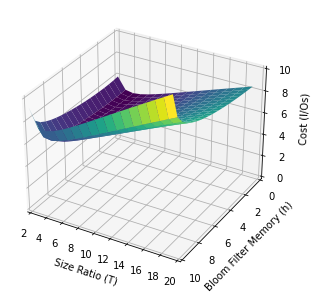

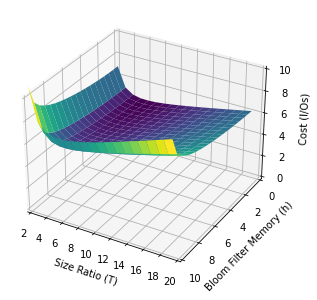

In [124]:
wl_id = 0
size_ratios, filter_mem = df['T'].unique(), df['h'].unique()

for wl_id in [0, 1, 2]:
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), subplot_kw={'projection': '3d'})
    _ = surface_plot(df, ax=ax, xlabel='Size Ratio (T)', ylabel='Bloom Filter Memory (h)', zlabel='Cost (I/Os)')